# Setup

In [1]:
# All import statements needed for the project
import json
import requests
import pandas as pd
import urllib.parse
import requests
import pathlib
from pathlib import Path
import psycopg2
import geoalchemy2 as gdb
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import sqlalchemy as db
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.animation as animation

from sqlalchemy.orm import declarative_base

In [2]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "qusZQnQU0ua9VbjGpXFDVhsbK"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "FINAL_PROJECT_DATA"
DB_USER = "sareayang"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

# Part 1: Data Preprocessing

In [4]:
def download_nyc_geojson_data(url: str,
                              file_name: str, 
                              force: bool = False) -> GeoDataFrame:
    """
    Download NYC GeoJSON data from a provided URL and saves it to a file.
    
    Keyword arguments:
    url (str) -- the URL from which the GeoJSON data will be downloaded
    file_name (str) -- the name of the file (without extension) to save the GeoJSON data
    force (bool, optional) -- if True, forces re-download of the file even if it exists locally (default is false)
    """
    
    filename = Path(file_name + '.geojson')
    
    if force or not filename.exists():
        print(f"Downloading {url} to {file_name}...")
    
        response = requests.get(url)
        text = response.text

        with open(file_name + '.geojson', 'w') as file:
            file.write(text)
        print(f"Done downloading {url}.")
        
    else:
        print(f"Reading from {file_name}...")
    
    gdf = gpd.read_file(file_name + '.geojson', driver = 'GeoJSON')
    return gdf

In [5]:
def download_and_clean_311_data():
    """Download and clean 311 complaints data."""
    
    url = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ"
    
    file_name = 'complaints_head(10000)'
    complaints = download_nyc_geojson_data(url, file_name, force=False)
    
    # choose the columns we neeed
    new_complaints = complaints[['created_date', 'incident_zip', 'complaint_type', 'geometry']]
    
    # normalize SRID to EPSG:4326
    new_complaints = new_complaints.to_crs(epsg=4326)
    
    # delete NaN
    columns_with_nan = new_complaints.columns[new_complaints.isnull().any()].tolist()
    
    for column_name in columns_with_nan:
        print("Processing column:", column_name)
        new_complaints = new_complaints.dropna(subset=[column_name])
        print("Removed rows with NaN value in", column_name)

    return new_complaints

In [6]:
def download_and_clean_tree_data():
    """Download and clean 2015 tree census data."""
    
    url = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson?$$app_token=RbFfvU4T8a7C7rDHaA9eqAkvZ"
    file_name = 'trees_head(10000)'
    trees = download_nyc_geojson_data(url, file_name, force=False)
    
    # normalize SRID to EPSG:4326
    trees = trees.to_crs(epsg=4326)
    
    # delete NaN
    columns_with_nan = trees.columns[trees.isnull().any()].tolist()
    
    for column_name in columns_with_nan:
        print("Processing column:", column_name)
        trees = trees.dropna(subset=[column_name])
        print("Removed rows with NaN value in", column_name)
        
    # choose the columns we neeed
    new_trees = trees[['tree_id', 'zipcode', 'spc_common', 'health', 'status','geometry']].copy()

    return new_trees

In [7]:
def load_and_clean_zipcodes(zipcode_datafile):
    """Load and clean NYC’s zip codes with geometric boundary data data."""
    
    zipcode_data = gpd.read_file(zipcode_datafile)
    
    zipcodes = zipcode_data[['ZIPCODE', 'geometry']]
    zipcodes = zipcodes.rename(columns={'ZIPCODE': 'zipcode'})
    
    # normalize SRID to EPSG:4326
    zipcodes = zipcodes.to_crs(epsg=4326)
    
    return zipcodes

In [8]:
def load_and_clean_zillow_data(rent_datafile):
    """Load and clean historical monthly average rents by zip code from Zillow."""
    
    zillow_rent_data = pd.read_csv(rent_datafile)
    
    columns_to_drop = ['RegionID', 'SizeRank', 'RegionType', 'State', 'StateName', 'City', 'Metro', 'CountyName']
    df_zillow_data = zillow_rent_data.drop(columns=columns_to_drop)
    
    # rename columns
    df_zillow_data = df_zillow_data.rename(columns={'RegionName': 'rent_zip'})
    
    # normalize rent data
    rents = pd.melt(df_zillow_data, id_vars=['rent_zip'], var_name='rent_date', value_name='rent_amount')
    
    # set datetime type
    rents['rent_date'] = pd.to_datetime(rents['rent_date'])
    rents['rent_zip']
    
    return rents

In [9]:
# ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZIPCODE_DATA_FILE = 'data/nyc_zipcodes.shp'
RENT_DATA_FILE = 'data/zillow_rent_data.csv'

In [10]:
def load_all_data():
    """Load all data."""
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data(RENT_DATA_FILE)
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [11]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

Reading from complaints_head(10000)...
Processing column: incident_zip
Removed rows with NaN value in incident_zip
Processing column: geometry
Removed rows with NaN value in geometry
Reading from trees_head(10000)...
Processing column: health
Removed rows with NaN value in health
Processing column: steward
Removed rows with NaN value in steward
Processing column: spc_common
Removed rows with NaN value in spc_common
Processing column: problems
Removed rows with NaN value in problems
Processing column: spc_latin
Removed rows with NaN value in spc_latin
Processing column: guards
Removed rows with NaN value in guards
Processing column: sidewalk
Removed rows with NaN value in sidewalk


In [12]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   263 non-null    object  
 1   geometry  263 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.2+ KB


In [13]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [14]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9862 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_date    9862 non-null   datetime64[ns]
 1   incident_zip    9862 non-null   object        
 2   complaint_type  9862 non-null   object        
 3   geometry        9862 non-null   geometry      
dtypes: datetime64[ns](1), geometry(1), object(2)
memory usage: 385.2+ KB


In [15]:
geodf_311_data.head()

,created_date,incident_zip,complaint_type,geometry
0,2023-12-07 12:00:00,11412,Derelict Vehicles,POINT (-73.75719 40.69898)
2,2023-12-07 12:00:00,10463,Derelict Vehicles,POINT (-73.90627 40.87876)
3,2023-12-06 23:57:00,11208,Street Light Condition,POINT (-73.86688 40.67826)
4,2023-12-06 23:52:56,10003,HEAT/HOT WATER,POINT (-73.98199 40.73435)
5,2023-12-06 23:52:56,10029,HEAT/HOT WATER,POINT (-73.93907 40.79101)


In [16]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9415 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tree_id     9415 non-null   object  
 1   zipcode     9415 non-null   object  
 2   spc_common  9415 non-null   object  
 3   health      9415 non-null   object  
 4   status      9415 non-null   object  
 5   geometry    9415 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 514.9+ KB


In [17]:
geodf_tree_data.head()

,tree_id,zipcode,spc_common,health,status,geometry
0,180683,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)


In [18]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705810 entries, 0 to 705809
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   rent_zip     705810 non-null  int64         
 1   rent_date    705810 non-null  datetime64[ns]
 2   rent_amount  250167 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.2 MB


In [19]:
df_zillow_data.head()

,rent_zip,rent_date,rent_amount
0,77494,2015-01-31,1606.206406
1,77449,2015-01-31,1257.814660
2,77084,2015-01-31,NaN
3,79936,2015-01-31,NaN
4,11385,2015-01-31,NaN


# Part 2: Storing Data

In [20]:
def setup_new_postgis_database(username, db_name):
    raise NotImplementedError()

### Creating Tables

In [21]:
engine = db.create_engine(DB_URL)

In [22]:
# define the SQL statements to create 4 tables using SQL
ZIPCODE_SCHEMA = """
CREATE TABLE nyc_zip_codes (
    id SERIAL PRIMARY KEY,
    zip_code INTEGER,
    geom POLYGON
)
"""

NYC_311_SCHEMA = """
CREATE TABLE complaints_311 (
    id SERIAL PRIMARY KEY,
    created_date TIMESTAMP,
    incident_zip INTEGER,
    complaints_type TEXT,
    geometry POINT
)
"""

NYC_TREE_SCHEMA = """
CREATE TABLE trees (
    id SERIAL PRIMARY KEY,
    tree_id INTEGER,
    tree_zip INTEGER,
    spc_common TEXT,
    health TEXT,
    status TEXT,
    geometry POINT
)
"""

ZILLOW_SCHEMA = """
CREATE TABLE rents (
    id SERIAL PRIMARY KEY,
    rent_zip INTEGER,
    rent_date DATE,
    rent NUMERIC(6)
)
"""

In [23]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [24]:
# execute the schema files to create tables using SQL
with engine.connect() as connection:
    
    connection.execute("DROP TABLE IF EXISTS nyc_zip_codes, complaints_311, trees, rents CASCADE") # if table already exists
    
    connection.execute(ZIPCODE_SCHEMA)
    connection.execute(NYC_311_SCHEMA)
    connection.execute(NYC_TREE_SCHEMA)
    connection.execute(ZILLOW_SCHEMA)

### Add Data to Database

In [25]:
# dataframe to sql table
df_zillow_data.to_sql('rents', con=engine, if_exists='replace', index=False)

# GeoDataFrame data into a PostGIS-enabled PostgreSQL table
geodf_311_data.to_postgis('complaints', con=engine, if_exists='replace', index=False)
geodf_zipcode_data.to_postgis('zipcodes', con=engine, if_exists='replace', index=False)
geodf_tree_data.to_postgis('trees', con=engine, if_exists='replace', index=False)

/Users/sareayang/anaconda3/lib/python3.11/site-packages/pandas/io/sql.py:1781: SAWarning: Did not recognize type 'point' of column 'geometry'
  self.meta.reflect(bind=self.connectable, only=[table_name], schema=schema)


In [26]:
### test: check point data type
# is 'USER-DEFINED' fine??? - yes
with engine.connect() as connection:
    result = connection.execute(
        """
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = 'complaints' AND column_name = 'geometry';
        """
    )

for row in result:
    print(row)

('geometry', 'USER-DEFINED')


In [27]:
### test: check the table
with engine.connect() as connection:
    result = connection.execute(
        """
        SELECT * FROM trees LIMIT 5
        """
    )

for row in result:
    print(row)

('180683', '11375', 'red maple', 'Fair', 'Alive', '0101000020E61000008DB8459F077652C0758170458E5C4440')
('200540', '11357', 'pin oak', 'Fair', 'Alive', '0101000020E6100000F6E0863E657452C0FE45186BA5654440')
('204026', '11211', 'honeylocust', 'Good', 'Alive', '0101000020E61000008D197161F17B52C08B7B89AFD95B4440')
('204337', '11211', 'honeylocust', 'Good', 'Alive', '0101000020E61000001DD33421CE7B52C0A5635632555B4440')
('189565', '11215', 'American linden', 'Good', 'Alive', '0101000020E610000046DB3C72767E52C0A98636F958554440')


In [28]:
### test: check the column names
with engine.connect() as connection:
    result = connection.execute(
        """
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = 'zipcodes';
        """
    )

for row in result:
    print(row)

('zipcode', 'text')
('geometry', 'USER-DEFINED')


# Part 3: Understanding the Data

In [29]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

## Query 1: Which area might be more calm to live in?
Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code. 

The query result should have two columns, one row per zip code, with the number of complaints in descending order.


In [30]:
QUERY_1_FILENAME = QUERY_DIR / "num_complaints_by_zipcode"

QUERY_1 = """
SELECT incident_zip, COUNT(*) AS complaints_count
FROM complaints
WHERE
    created_date BETWEEN '2022-10-01T00:00:00.000' AND '2023-09-30T23:59:59.999'
GROUP BY incident_zip
"""

In [31]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [32]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_1)

for row in result:
    print(row)

## Query 2: Where has the most greenery?
Using just the trees table, which 10 zip codes have the most trees?

The query result should have two columns, 10 rows. The rows should be sorted by the total number of trees, descending.


In [33]:
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_with_most_trees"

# table column name is the same as dataframe, not schema!!!
QUERY_2 = """
SELECT zipcode, COUNT(*) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [34]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [35]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_2)

for row in result:
    print(row)

('10306', 422)
('11105', 338)
('11375', 245)
('10457', 233)
('11215', 233)
('11230', 231)
('11372', 219)
('10024', 218)
('10312', 217)
('10458', 187)


## Query 3: Can I afford a place in the areas with the most trees?
Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code?

The query should have a JOIN statement. The query result should have two columns (not three) and 10 rows. The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128. 

In [36]:
QUERY_3_FILENAME = QUERY_DIR / "avg_rent_for_top_10_zipcodes_with_most_trees"

QUERY_3 = """
WITH top10_zipcodes AS (
    SELECT zipcode, COUNT(*) AS total_trees
    FROM trees
    GROUP BY zipcode
    ORDER BY total_trees DESC
    LIMIT 10
)

SELECT t.zipcode, ROUND(AVG(r.rent_amount)::numeric, 2) AS average_rent
FROM rents r
JOIN trees t ON t.zipcode = r.rent_zip::text
WHERE DATE_PART('month', r.rent_date) = 8
    AND DATE_PART('year', r.rent_date) = 2023
    AND r.rent_zip::text IN (SELECT zipcode FROM top10_zipcodes)
GROUP BY t.zipcode
ORDER BY (SELECT total_trees FROM top10_zipcodes WHERE zipcode = t.zipcode) DESC;
"""

In [37]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

In [38]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_3)

for row in result:
    print(row)

('10306', Decimal('2331.54'))
('11105', Decimal('2852.73'))
('11375', Decimal('2743.40'))
('11215', Decimal('3575.65'))
('10457', Decimal('2183.97'))
('11230', Decimal('2657.04'))
('11372', Decimal('2384.08'))
('10024', Decimal('3797.94'))
('10312', Decimal('1775.09'))
('10458', Decimal('1991.63'))


## Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?
For the month of January 2023, return the 5 zip codes with the lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count and complaint count for each zip code by using JOIN statements.

The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows: five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

In [39]:
QUERY_4_FILENAME = QUERY_DIR / "rent_trees_complaints_correlation"

QUERY_4 = """
WITH RentData AS (
    SELECT CAST(r.rent_zip AS TEXT) AS zipcode, 
           CAST(AVG(r.rent_amount) AS DECIMAL(10, 2)) AS average_rent
    FROM rents r
    WHERE DATE_PART('month', r.rent_date) = 1
      AND DATE_PART('year', r.rent_date) = 2023
    GROUP BY r.rent_zip
),
TreeData AS (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode
),
ComplaintData AS (
    SELECT incident_zip AS zipcode, COUNT(*) AS complaint_count
    FROM complaints
    WHERE DATE_PART('month', created_date) = 1
      AND DATE_PART('year', created_date) = 2023
    GROUP BY incident_zip
),
LowestRent AS (
    SELECT * FROM RentData
    ORDER BY average_rent ASC
    LIMIT 5
),
HighestRent AS (
    SELECT * FROM RentData
    ORDER BY average_rent DESC
    LIMIT 5
)
SELECT lr.zipcode,
       lr.average_rent AS formatted_rent,
       COALESCE(td.tree_count, 0) AS tree_count,
       COALESCE(cd.complaint_count, 0) AS complaint_count
FROM LowestRent lr
LEFT JOIN TreeData td ON lr.zipcode = td.zipcode
LEFT JOIN ComplaintData cd ON lr.zipcode = cd.zipcode
UNION ALL
SELECT hr.zipcode,
       hr.average_rent AS formatted_rent,
       COALESCE(td.tree_count, 0) AS tree_count,
       COALESCE(cd.complaint_count, 0) AS complaint_count
FROM HighestRent hr
LEFT JOIN TreeData td ON hr.zipcode = td.zipcode
LEFT JOIN ComplaintData cd ON hr.zipcode = cd.zipcode;
"""

In [40]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [41]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_4)

for row in result:
    print(row)

('50702', Decimal('723.07'), 0, 0)
('48503', Decimal('701.58'), 0, 0)
('72114', Decimal('723.04'), 0, 0)
('67501', Decimal('631.74'), 0, 0)
('61832', Decimal('648.49'), 0, 0)
('1060', None, 0, 0)
('1108', None, 0, 0)
('1002', None, 0, 0)
('1201', None, 0, 0)
('1375', None, 0, 0)


## Query 5: Where has the most greenery (take 2)?
Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.

The query should have a JOIN statement. The query results should match exactly the results of Query 2.

In [42]:
QUERY_5_FILENAME = QUERY_DIR / "top_10_zipcodes_with_most_trees_by_geometry"

QUERY_5 = """
SELECT z.zipcode, COUNT(*) AS total_trees
FROM zipcodes z
JOIN trees AS t ON ST_Contains(z.geometry, t.geometry)
GROUP BY z.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [43]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [44]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_5)

for row in result:
    print(row)

('10306', 422)
('11105', 338)
('11375', 245)
('10457', 233)
('11215', 233)
('11230', 231)
('11372', 219)
('10024', 218)
('10312', 217)
('10458', 187)


## Query 6: What is the immediate area like?
Using the following coordinate pair on campus, which trees are within ½ mile radius of this point?
Latitude: 40.80737875669467, Longitude: -73.96253174434912

The result should have 5 columns (ID, species, health, status, and coordinate location of each tree).

You may use regular Python to help construct the geometric object needed for setting the radius in the query.


In [45]:
target_latitude = 40.80737875669467
target_longitude = -73.96253174434912

target_point = Point(target_longitude, target_latitude)

# Create a circle with a radius of 0.5 miles around the target location
radius = 0.5  # in miles
circle_buffer = target_point.buffer(radius / 69)  # Assuming 1 degree of latitude is approximately 69 miles

gdf_circle = gpd.GeoDataFrame(geometry=[circle_buffer])

In [46]:
QUERY_6_FILENAME = QUERY_DIR / "trees_within_coordinate_pair"

QUERY_6 = f"""
SELECT tree_id, spc_common, health, status, ST_AsText(geometry) AS coordinate_location
FROM trees
WHERE ST_Intersects(geometry, ST_GeomFromText('{circle_buffer.wkt}', 4326))
"""

In [47]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [48]:
# execute the query
with engine.connect() as connection:
    result = connection.execute(QUERY_5)

for row in result:
    print(row)

('10306', 422)
('11105', 338)
('11375', 245)
('10457', 233)
('11215', 233)
('11230', 231)
('11372', 219)
('10024', 218)
('10312', 217)
('10458', 187)


# Part 4: Visualizing Data

In [49]:
# Render graphics directly in the notebook without having to call plt.show
%matplotlib inline
plt.style.use("seaborn-dark")  # Choose a color palett

/var/folders/dq/5cb25m050gdgm4z55x13r0m00000gn/T/ipykernel_18988/897146302.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")  #choose a color palett


In [50]:
# Queries to select data
query1 = 'SELECT * FROM rents'
query2 = 'SELECT * FROM complaints'
query3 = 'SELECT * FROM trees'
query4 = 'SELECT * FROM zipcodes'

In [51]:
# Read spatial data into a GeoDataFrame using geopandas read_postgis() function
rent_data = pd.read_sql(query1, engine)

complaint_data = gpd.read_postgis(query2, con=engine, geom_col='geometry')
tree_data = gpd.read_postgis(query3, con=engine, geom_col='geometry')
zipcode_data = gpd.read_postgis(query4, con=engine, geom_col='geometry')

## Visualization 1: What can I expect to put up with in NYC?
First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 

Then, create an appropriate visualization for the number of complaints per day over $timeframe for those complaint types.  

In [52]:
# final data selection - skipped for now
start_date = pd.Timestamp('2022-10-01')
end_date = pd.Timestamp('2023-09-30')

df_nyc = complaint_data.loc[(complaint_data['created_date'] >= start_date) 
                              & (complaint_data['created_date'] <= end_date)]

In [53]:
### test: use current data
top_3_types = complaint_data['complaint_type'].value_counts().nlargest(3).index.tolist()
df_top3 =  complaint_data[complaint_data['complaint_type'].isin(top_3_types)].copy()

df_top3['created_date'] = pd.to_datetime(df_top3['created_date'])

df_top3_grouped = df_top3.groupby(df_top3['created_date'].dt.date)['incident_zip'].size().reset_index(name='count')

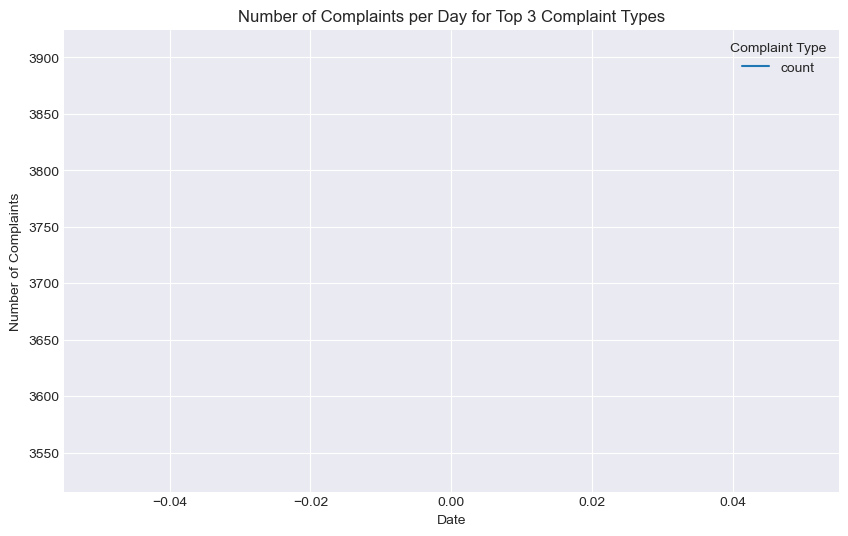

In [54]:
# visulization
df_top3_grouped.plot(kind='line', figsize=(10, 6))
plt.title('Number of Complaints per Day for Top 3 Complaint Types')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend(title='Complaint Type')
plt.grid(True)

### Extra credit 1: animation

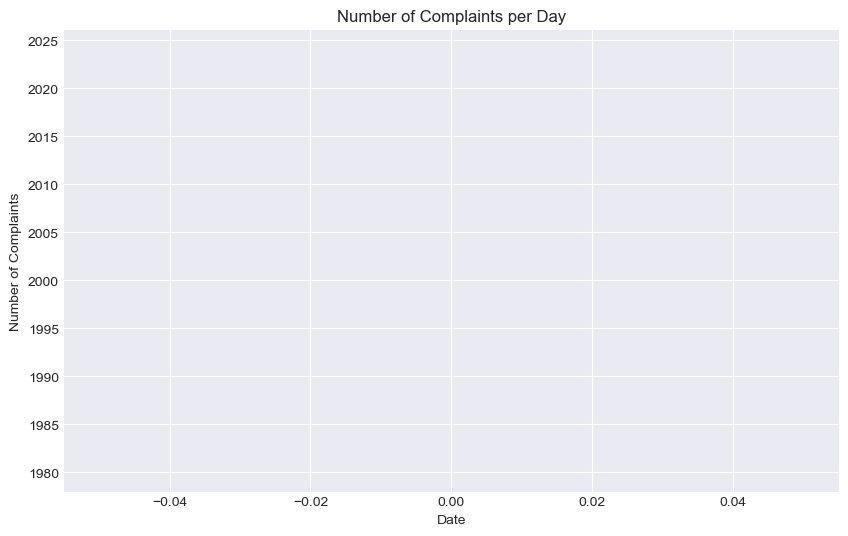

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

# Function to update the plot for each frame in the animation
def update(frame: int):
    """
    A Function for the animation
    
    Parameters:
    frame(int): Frame number for the animation
    """
    ax.clear()
    ax.plot(df_top3_grouped.index[:frame+1], df_top3_grouped.values[:frame+1])
    ax.set_title('Number of Complaints per Day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Complaints')
    ax.grid(True)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(df_top3_grouped), interval=100, repeat=False)

## Visualization 2: What are the most common complaints in the immediate area?¶
Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive).

In [58]:
# final data selection - skipped for now
start_date = pd.Timestamp('2018-10-01')
end_date = pd.Timestamp('2023-09-30')

df_zipcode_10027 = complaint_data.loc[(complaint_data['incident_zip'] == 10027.0) &
                          (complaint_data['created_date'] >= start_date) &
                          (complaint_data['created_date'] <= end_date)]

In [59]:
# test: use current data
df_top10 = complaint_data['complaint_type'].value_counts().nlargest(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'HEAT/HOT WATER'),
  Text(1, 0, 'Illegal Parking'),
  Text(2, 0, 'Noise - Helicopter'),
  Text(3, 0, 'Noise - Residential'),
  Text(4, 0, 'Blocked Driveway'),
  Text(5, 0, 'UNSANITARY CONDITION'),
  Text(6, 0, 'PLUMBING'),
  Text(7, 0, 'PAINT/PLASTER'),
  Text(8, 0, 'DOOR/WINDOW'),
  Text(9, 0, 'Abandoned Vehicle')])

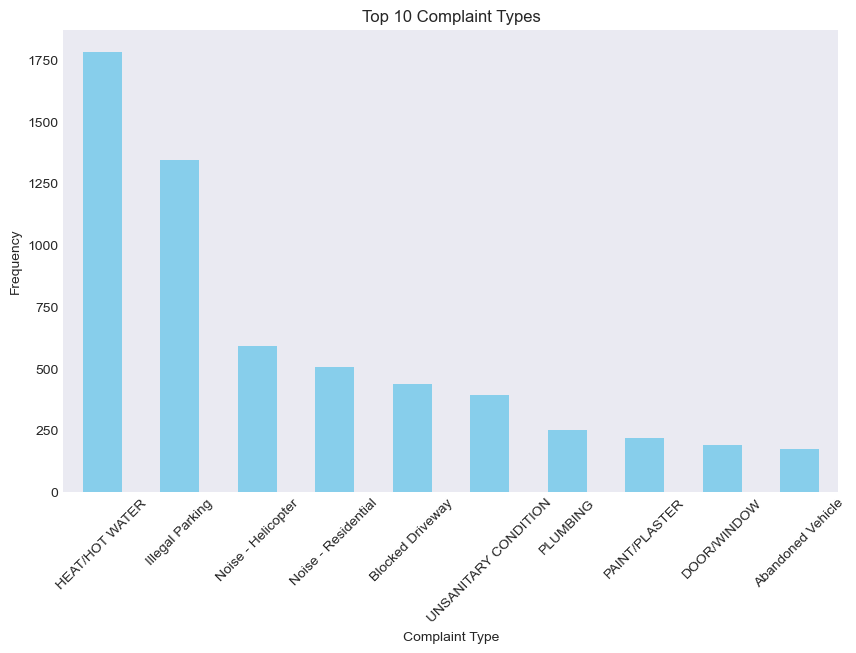

In [60]:
# visualization
plt.figure(figsize=(10, 6))

df_top10.plot(kind='bar', color='skyblue')

plt.xlabel('Complaint Type')
plt.ylabel('Frequency')
plt.title('Top 10 Complaint Types')

plt.xticks(rotation=45)

## Visualization 3: Is there any correlation between rent, trees, and complaints at all?
Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the other subplot shows rent compared to the number of complaints by zip code.

In [61]:
# filter and merge data
rent_data_filtered = rent_data[(rent_data['rent_date'] >= '2015-01-01') & (rent_data['rent_date'] <= '2023-09-30')]
rent_data_filtered['rent_zip'] = rent_data_filtered['rent_zip'].astype(str) # match column data type

complaint_data_filtered = complaint_data[(complaint_data['created_date'] >= '2015-01-01') & (complaint_data['created_date'] <= '2023-09-30')]
complaint_by_zip = complaint_data_filtered.groupby('incident_zip').size().reset_index(name='num_complaints')

trees_by_zip = tree_data.groupby('zipcode').size().reset_index(name='num_trees')

merged_data = rent_data_filtered.merge(trees_by_zip, left_on='rent_zip', right_on='zipcode', how='inner')
merged_data = merged_data.merge(complaint_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')

In [62]:
# test:
# rent_data_filtered = rent_data[(rent_data['rent_date'] >= '2015-01-01') & (rent_data['rent_date'] <= '2023-09-30')]
rent_data['rent_zip'] = rent_data['rent_zip'].astype(str) # match column data type

# complaint_data_filtered = complaint_data[(complaint_data['created_date'] >= '2015-01-01') & (complaint_data['created_date'] <= '2023-09-30')]
complaint_by_zip = complaint_data.groupby('incident_zip').size().reset_index(name='num_complaints')

trees_by_zip = tree_data.groupby('zipcode').size().reset_index(name='num_trees')

merged_data = rent_data.merge(trees_by_zip, left_on='rent_zip', right_on='zipcode', how='inner')
merged_data = merged_data.merge(complaint_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')

Text(0.5, 0, 'Rent')

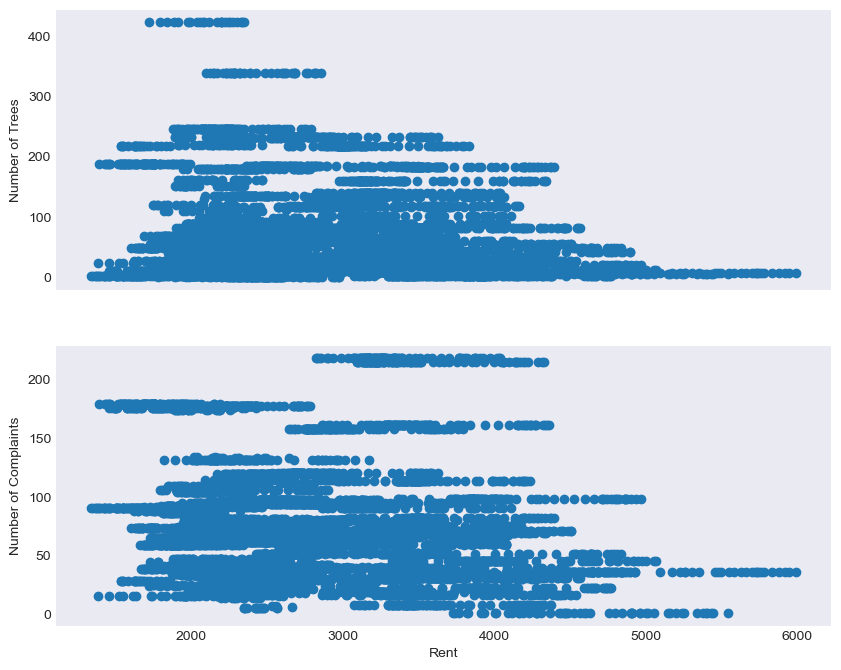

In [63]:
# visualization
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.scatter(merged_data['rent_amount'], merged_data['num_trees'])
ax1.set_ylabel('Number of Trees')

ax2.scatter(merged_data['rent_amount'], merged_data['num_complaints'])
ax2.set_ylabel('Number of Complaints')

plt.xlabel('Rent')

## Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?
Create a boxplot, where the x-axis is average rent in September 2023, separated into $1000 bins (i.e. $0-1000, $1001-2000, etc), and the y-axis is the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).

In [64]:
# Define bin ranges and labels for rent amounts
bins = [0, 1000, 2000, 3000, 4000, np.inf]
bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001+']


# Filter, group, and merge data
rent_data_sept_2023 = rent_data[rent_data['rent_date'] == '2023-09-30'].copy()

rent_data_sept_2023['rent_bin'] = pd.cut(rent_data_sept_2023['rent_amount'], bins=bins, labels=bin_labels)
rent_data_sept_2023['rent_zip'] = rent_data_sept_2023['rent_zip'].astype(str) # match column data type

complaints_data_filtered = complaint_data[(complaint_data['created_date'] >= '2022-10-01') & (complaint_data['created_date'] <= '2023-09-30')]

complaints_by_zip = complaints_data_filtered.groupby('incident_zip').size().reset_index(name='num_complaints')

merged_data = rent_data_sept_2023.merge(complaints_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')

In [65]:
### test:
# Define bin ranges and labels for rent amounts
bins = [0, 1000, 2000, 3000, 4000, np.inf]
bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001+']

# Filter, group, and merge data
#rent_data_sept_2023 = rent_data[(rent_data['rent_date'] >= '2023-09-01') & (rent_data['rent_date'] <= '2023-09-30')]

rent_data['rent_bin'] = pd.cut(rent_data['rent_amount'], bins=bins, labels=bin_labels)
rent_data['rent_zip'] = rent_data['rent_zip'].astype(str) # match column data type

#complaints_data_filtered = complaints_data[(complaints_data['created_date'] >= '2022-10-01') & (complaints_data['created_date'] <= '2023-09-30')]

complaints_by_zip = complaint_data.groupby('incident_zip').size().reset_index(name='num_complaints')

merged_data = rent_data.merge(complaints_by_zip, left_on='rent_zip', right_on='incident_zip', how='inner')

Text(0.5, 1.0, 'Boxplot of Rent vs. 311 Complaints')

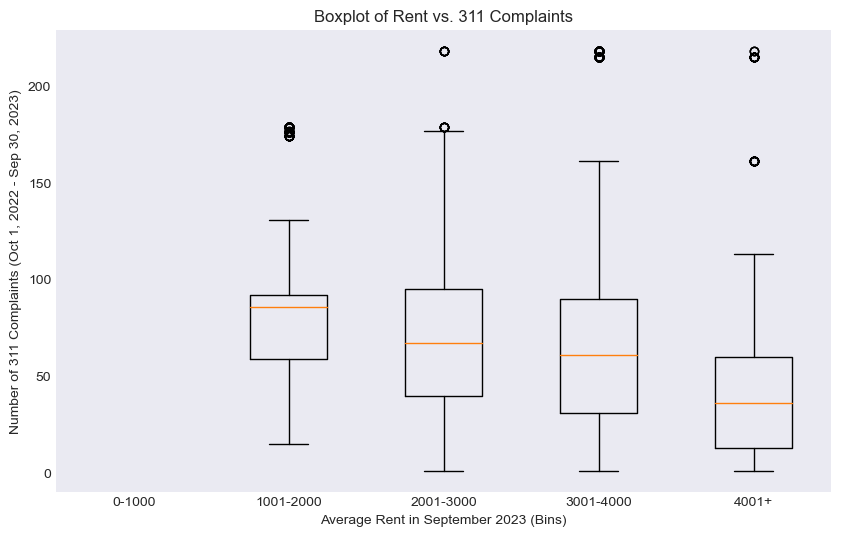

In [66]:
# visulization
plt.figure(figsize=(10, 6))
plt.boxplot([merged_data[merged_data['rent_bin'] == label]['num_complaints'] for label in bin_labels], labels=bin_labels)
plt.xlabel('Average Rent in September 2023 (Bins)')
plt.ylabel('Number of 311 Complaints (Oct 1, 2022 - Sep 30, 2023)')
plt.title('Boxplot of Rent vs. 311 Complaints')

## Visualization 5: Where were the recent 311 incidents reported from in the immediate area?
Create a geospatial plot of the coordinates of reported 311 incidents that happened between January 1st, 2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of the same coordinate from Query 6 in Part 3.

In [67]:
complaints_data_filtered = complaint_data[(complaint_data['created_date'] >= '2023-01-01') & (complaint_data['created_date'] <= '2023-09-30')]

# Create a Point geometry
target_latitude = 40.80737875669467
target_longitude = -73.96253174434912

target_point = Point(target_longitude, target_latitude)

# Calculate distance between incidents and the target location
complaints_data_filtered['distance_to_target'] = complaints_data_filtered['geometry'].distance(target_point)

# Filter incidents within a 1-kilometer radius of the target location
incidents_within_radius = complaints_data_filtered[complaints_data_filtered['distance_to_target'] <= 1000]  # Distance in meters (1 kilometer = 1000 meters)

/var/folders/dq/5cb25m050gdgm4z55x13r0m00000gn/T/ipykernel_18988/1456395419.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  complaints_data_filtered['distance_to_target'] = complaints_data_filtered['geometry'].distance(target_point)


In [68]:
### test:

# Create a Point geometry
target_latitude = 40.80737875669467
target_longitude = -73.96253174434912

target_point = Point(target_longitude, target_latitude)

# Calculate distance between incidents and the target location
complaint_data['distance_to_target'] = complaint_data['geometry'].distance(target_point)

# Filter incidents within a 1-kilometer radius of the target location
incidents_within_radius = complaint_data[complaint_data['distance_to_target'] <= 10000]  # Distance in meters (1 kilometer = 1000 meters)

/var/folders/dq/5cb25m050gdgm4z55x13r0m00000gn/T/ipykernel_18988/571161294.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  complaint_data['distance_to_target'] = complaint_data['geometry'].distance(target_point)


/var/folders/dq/5cb25m050gdgm4z55x13r0m00000gn/T/ipykernel_18988/125680897.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(65.95833333333333, 0.5, 'Latitude')

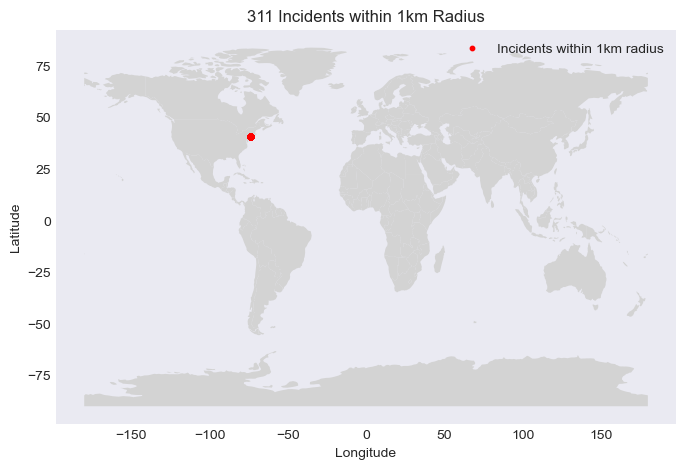

In [69]:
# visualization
fig, ax = plt.subplots(figsize=(8, 8))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey')
incidents_within_radius.plot(ax=ax, markersize=10, color='red', marker='o', label='Incidents within 1km radius')
ax.legend()
plt.title('311 Incidents within 1km Radius')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?
Create a geospatial plot of two sets of data: the coordinates of trees in NYC, and the coordinates of "New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 (inclusive). 

In [70]:
# Filter 'New Tree Request' 311 complaints data for the specified date range
new_tree_requests = complaint_data[
    (complaint_data['complaint_type'] == 'New Tree Request') &
    (complaint_data['created_date'] >= '2018-10-01') &
    (complaint_data['created_date'] <= '2023-09-30')
]

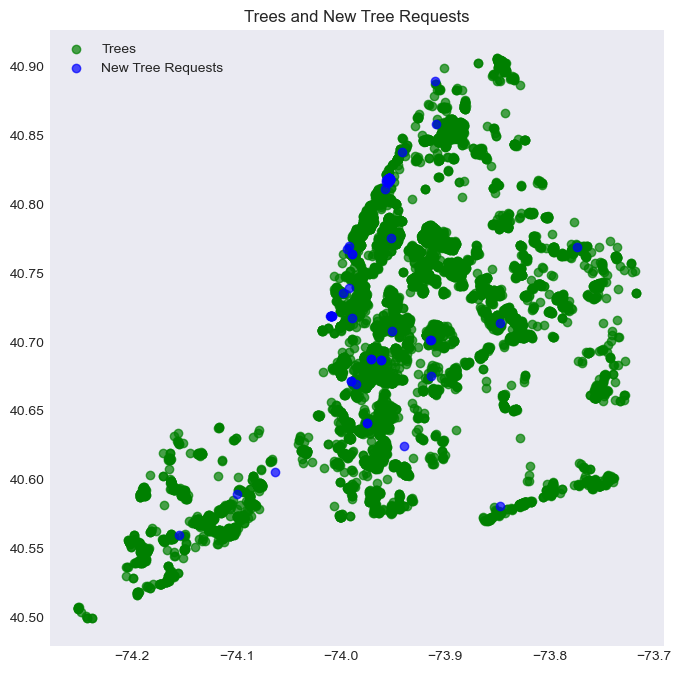

In [71]:
# test:
fig, ax = plt.subplots(figsize=(10, 8))

tree_data.plot(ax=ax, color='green', alpha=0.7, label='Trees')
complaint_data[complaint_data['complaint_type'] == 'New Tree Request'].plot(ax=ax, color='blue', alpha=0.7, label='New Tree Requests')

plt.title('Trees and New Tree Requests')
plt.legend()